<a id='0.1'></a>
## 0.1 load required packages

In [2]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *

print(os.getpid())

# library design specific tools
from ImageAnalysis3.library_tools import LibraryDesigner as ld
from ImageAnalysis3.library_tools import LibraryTools as lt
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

8432


In [3]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain'
if not os.path.exists(pool_folder):
    print(f"Create pool_folder: {pool_folder}")
    os.makedirs(pool_folder)
else:
    print(f"Use pool_folder: {pool_folder}")
    
# folder for sub-pool
library_folder = os.path.join(pool_folder, f'human_brain_promoter_enhancer_v2')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)
else:
    print(f"Use library_folder: {library_folder}")

Use pool_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain
Use library_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2


## 3.1 design readout mapping dict (region_to_readout)

idea for this library:

1. each gene has 3 on-bits from 99 total-bits

3. 

In [5]:
on_num = 3
total_num = 95

encoding_file = os.path.join(library_folder, f'covering_v_{total_num}_k_{on_num}_t_2.txt')
loaded_bits = []

with open(encoding_file, 'r') as _handle:
    # start reading
    _lines = _handle.read().split('\n')
    for _line in _lines:
        _bits = [int(_i)-1 for _i in _line.split(' ') if len(_i) > 0]
        loaded_bits.append(_bits)

loaded_bits = np.array(loaded_bits, dtype=np.int32)
print(np.shape(loaded_bits))

(1489, 3)


In [6]:
def convert_bits_to_matrix(bits):
    _matrix = np.ones([len(bits), np.max(bits)+1], dtype=np.int32) * -1
    for _i, _b in enumerate(bits):
        _matrix[_i, _b] = 1
    return _matrix

In [7]:
# remove redundant bits
kept_bits = loaded_bits.copy()
kept_inds = np.zeros(len(kept_bits))
while np.sum(kept_inds) != len(kept_inds):
    kept_inds = np.ones(len(kept_bits), dtype=bool)
    _kept_mat = convert_bits_to_matrix(kept_bits)
    _dists = (total_num - (_kept_mat @ _kept_mat.T)) / 2
    _x, _y = np.where((_dists > 0) * (_dists <= 3))
    if len(_x) > 0:
        kept_inds[_x[0]] = False
        kept_bits = kept_bits[kept_inds]
        print(np.sum(kept_inds), kept_inds[_x[0]])
print(kept_bits.shape)

1488 False
1487 False
(1487, 3)


In [8]:
encoding_bits = kept_bits.copy()
encoding_mat = convert_bits_to_matrix(encoding_bits)

In [10]:
encoding_folder = os.path.join(library_folder, 'Encoding_design')
if not os.path.exists(encoding_folder):
    os.makedirs(encoding_folder)
    print(encoding_folder)

pickle.dump(encoding_bits, open(os.path.join(encoding_folder, f'encoding_bits_total-{total_num}_on-{on_num}.pkl'), 'wb'))

In [11]:
chr_2_region_num = pickle.load( open(os.path.join(library_folder, 'chr_2_final_region_num.pkl'), 'rb'))

In [12]:
# assign into different chromosomes
cand_bits = list(encoding_bits)
total_bit_usage = np.zeros(np.max(cand_bits)+1)
chr_bit_usage_dict = {}
chr_2_region_bits = {}
for _chr, _num in sorted(chr_2_region_num.items(), key=lambda v:-v[1]):
    print(_chr, _num)
    chr_2_region_bits[_chr] = []
    # try to assign as even as possible for this chr
    _chr_bit_usage = np.zeros(np.max(cand_bits)+1)
    
    while len(chr_2_region_bits[_chr]) < _num:
        # for each cand_bit, estimate overlap
        _chr_usage_list = [np.sum(_chr_bit_usage[_bits]**2) for _bits in cand_bits]
        _total_usage_list = [np.sum(total_bit_usage[_bits]**2) for _bits in cand_bits]
        # find the least overlapping candidate
        _least_overlap_inds = []
        _chr_usage_th = np.min(_chr_usage_list)
        _total_usage_th = np.min(_total_usage_list)
        while len(_least_overlap_inds) == 0:
            _least_overlap_inds = np.intersect1d(np.where(np.array(_chr_usage_list)<=_chr_usage_th)[0], 
                                                np.where(np.array(_total_usage_list)<=_total_usage_th)[0])
            _total_usage_th += 1
        
        _rand_least_overlap_ind = _least_overlap_inds[np.random.randint(len(_least_overlap_inds))]
        
        print(_chr_bit_usage[cand_bits[_rand_least_overlap_ind]], 
              total_bit_usage[cand_bits[_rand_least_overlap_ind]],  
              cand_bits[_rand_least_overlap_ind],
              )
        
        
        # remove this code from cand_bit pool
        _sel_cand = cand_bits.pop(_rand_least_overlap_ind)


        # update overlap list and chr_2_region_bits
        chr_2_region_bits[_chr].append(_sel_cand)
        _chr_bit_usage[_sel_cand] += 1
        total_bit_usage[_sel_cand] += 1
    
    chr_bit_usage_dict[_chr] = _chr_bit_usage

1 103
[0. 0. 0.] [0. 0. 0.] [ 0 63 68]
[0. 0. 0.] [0. 0. 0.] [18 48 76]
[0. 0. 0.] [0. 0. 0.] [49 50 93]
[0. 0. 0.] [0. 0. 0.] [46 74 84]
[0. 0. 0.] [0. 0. 0.] [ 2  7 24]
[0. 0. 0.] [0. 0. 0.] [32 61 78]
[0. 0. 0.] [0. 0. 0.] [15 33 60]
[0. 0. 0.] [0. 0. 0.] [ 3 21 37]
[0. 0. 0.] [0. 0. 0.] [17 28 64]
[0. 0. 0.] [0. 0. 0.] [31 45 56]
[0. 0. 0.] [0. 0. 0.] [25 38 71]
[0. 0. 0.] [0. 0. 0.] [55 79 82]
[0. 0. 0.] [0. 0. 0.] [23 62 65]
[0. 0. 0.] [0. 0. 0.] [11 59 88]
[0. 0. 0.] [0. 0. 0.] [30 70 81]
[0. 0. 0.] [0. 0. 0.] [ 6 42 91]
[0. 0. 0.] [0. 0. 0.] [10 47 51]
[0. 0. 0.] [0. 0. 0.] [ 4  5 14]
[0. 0. 0.] [0. 0. 0.] [43 53 77]
[0. 0. 0.] [0. 0. 0.] [20 36 44]
[0. 0. 0.] [0. 0. 0.] [ 9 13 19]
[0. 0. 0.] [0. 0. 0.] [29 52 80]
[0. 0. 0.] [0. 0. 0.] [54 85 86]
[0. 0. 0.] [0. 0. 0.] [35 39 75]
[0. 0. 0.] [0. 0. 0.] [22 66 87]
[0. 0. 0.] [0. 0. 0.] [ 1 26 34]
[0. 0. 0.] [0. 0. 0.] [16 69 83]
[0. 0. 0.] [0. 0. 0.] [41 67 73]
[0. 0. 0.] [0. 0. 0.] [40 89 92]
[0. 1. 0.] [0. 1. 0.] [27 38 58]
[0. 

[0. 0. 0.] [7. 7. 7.] [19 23 90]
[0. 0. 0.] [7. 7. 8.] [ 8 50 62]
[0. 0. 0.] [8. 7. 7.] [ 4 11 38]
[0. 0. 0.] [7. 7. 8.] [41 78 94]
[0. 0. 0.] [8. 7. 7.] [ 5 43 67]
[0. 0. 0.] [8. 7. 7.] [ 0 22 72]
[0. 0. 0.] [8. 8. 7.] [25 52 93]
[0. 0. 0.] [8. 8. 8.] [13 58 82]
[0. 0. 0.] [8. 8. 8.] [51 60 64]
[0. 0. 0.] [8. 8. 8.] [ 7 45 65]
[0. 0. 0.] [8. 8. 8.] [40 76 87]
[0. 0. 0.] [8. 8. 8.] [10 36 80]
[0. 0. 0.] [8. 8. 8.] [39 47 68]
[0. 0. 0.] [8. 8. 8.] [ 3 31 46]
[0. 0. 0.] [8. 8. 8.] [32 54 81]
[0. 0. 0.] [8. 8. 8.] [ 1 27 30]
[0. 0. 0.] [8. 8. 8.] [37 55 84]
[0. 0. 0.] [8. 8. 8.] [ 9 35 59]
[0. 0. 0.] [8. 8. 8.] [ 2 33 70]
[0. 0. 0.] [8. 8. 8.] [15 17 77]
[0. 0. 0.] [8. 8. 8.] [24 28 88]
[0. 1. 0.] [8. 8. 8.] [ 6 79 83]
[0. 1. 0.] [8. 8. 8.] [21 43 57]
[0. 1. 0.] [9. 8. 8.] [16 49 91]
[0. 1. 1.] [8. 8. 8.] [42 44 86]
[1. 1. 0.] [8. 8. 8.] [12 50 63]
[1. 1. 1.] [8. 8. 8.] [66 67 74]
[1. 1. 1.] [8. 8. 8.] [14 61 75]
[1. 1. 1.] [8. 8. 8.] [22 69 93]
[1. 1. 1.] [8. 8. 8.] [20 29 73]
[1. 1. 1.]

[0. 0. 0.] [15. 15. 15.] [38 63 74]
[0. 0. 0.] [15. 15. 15.] [ 3 23 27]
[0. 0. 0.] [15. 15. 15.] [13 14 48]
[0. 0. 0.] [15. 15. 15.] [16 66 86]
[0. 0. 0.] [15. 15. 15.] [19 36 91]
[0. 0. 0.] [15. 15. 15.] [29 42 84]
[0. 0. 0.] [15. 15. 15.] [ 8 15 46]
[0. 0. 0.] [15. 15. 15.] [ 4 34 37]
[0. 0. 0.] [15. 15. 15.] [43 44 78]
[0. 0. 0.] [15. 15. 15.] [60 71 80]
[0. 0. 0.] [15. 15. 15.] [40 58 73]
[0. 0. 0.] [15. 16. 15.] [24 50 72]
[0. 0. 0.] [16. 15. 15.] [ 5 20 54]
[0. 0. 0.] [16. 16. 15.] [ 6 88 93]
[0. 0. 0.] [16. 16. 15.] [33 49 76]
[0. 1. 0.] [15. 16. 15.] [31 47 69]
[1. 0. 0.] [16. 15. 15.] [25 61 92]
[0. 0. 1.] [15. 15. 16.] [22 35 62]
[0. 0. 1.] [16. 16. 16.] [28 68 87]
[1. 1. 1.] [16. 16. 15.] [15 30 94]
[1. 1. 1.] [15. 16. 16.] [ 9 18 26]
[1. 1. 1.] [16. 16. 16.] [37 42 73]
[1. 1. 1.] [16. 16. 16.] [ 0 40 59]
[1. 1. 1.] [16. 16. 16.] [45 57 81]
[1. 1. 1.] [16. 16. 16.] [17 78 92]
[1. 1. 1.] [16. 16. 16.] [ 4 56 77]
[1. 1. 1.] [16. 16. 16.] [20 27 48]
[1. 1. 1.] [16. 16. 16.] [19

[0. 0. 0.] [22. 22. 22.] [59 69 92]
[0. 0. 0.] [22. 22. 23.] [16 19 34]
[0. 0. 0.] [22. 22. 23.] [17 25 67]
[0. 0. 0.] [23. 23. 22.] [22 61 84]
[0. 0. 0.] [23. 23. 22.] [ 3 51 94]
[1. 0. 0.] [23. 22. 22.] [ 6 65 68]
[1. 0. 0.] [23. 22. 22.] [13 83 90]
[0. 1. 0.] [23. 23. 23.] [40 82 85]
[1. 0. 0.] [23. 23. 23.] [ 1 18 49]
[1. 0. 0.] [23. 23. 23.] [32 55 62]
[0. 1. 0.] [23. 23. 23.] [ 4 72 75]
[1. 0. 1.] [23. 23. 23.] [45 52 91]
[1. 1. 0.] [23. 23. 23.] [63 73 79]
[1. 1. 1.] [23. 23. 23.] [24 78 80]
[1. 1. 1.] [23. 23. 23.] [87 92 93]
[1. 1. 1.] [23. 23. 23.] [58 74 81]
[1. 1. 1.] [23. 23. 23.] [28 48 71]
[1. 1. 1.] [23. 23. 23.] [38 42 69]
[1. 1. 1.] [23. 23. 23.] [37 70 76]
20 38
[0. 0. 0.] [23. 23. 23.] [12 19 27]
[0. 0. 0.] [23. 23. 23.] [14 64 77]
[0. 0. 0.] [23. 23. 23.] [10 17 84]
[0. 0. 0.] [23. 23. 23.] [ 8 26 29]
[0. 0. 0.] [23. 23. 23.] [35 36 66]
[0. 0. 0.] [23. 23. 23.] [ 9 15 47]
[0. 0. 0.] [23. 23. 23.] [20 41 65]
[0. 0. 0.] [23. 23. 23.] [21 33 56]
[0. 0. 0.] [23. 23. 23

[0. 0. 0.] [30. 30. 30.] [27 31 41]
[0. 0. 0.] [30. 30. 30.] [14 79 94]
[0. 0. 0.] [30. 30. 30.] [29 51 78]
X 6
[0. 0. 0.] [30. 30. 30.] [10 38 87]
[0. 0. 0.] [30. 31. 30.] [43 58 88]
[0. 0. 0.] [30. 31. 30.] [25 44 66]
[0. 0. 0.] [30. 31. 30.] [34 48 57]
[0. 0. 0.] [30. 31. 30.] [ 7 14 49]
[0. 0. 0.] [31. 30. 30.] [59 73 82]


<IPython.core.display.Javascript object>


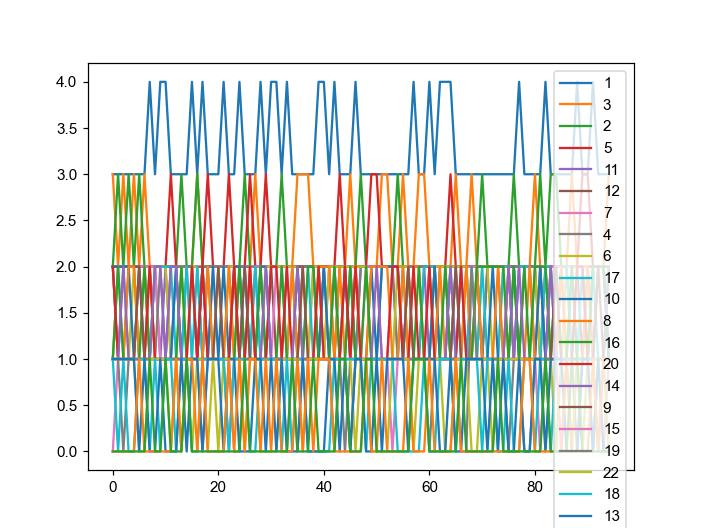

In [14]:
fig, ax = plt.subplots()
for _chr, _chr_bit_usage in chr_bit_usage_dict.items():
    ax.plot(_chr_bit_usage, label=_chr, )
    
ax.legend()

In [15]:
def calculate_closest_overlap(code_list, code, _localtion):
    """Calculate the closest neighbor of certain code at certain location"""
    if _localtion > len(code_list) or _localtion < 0:
        raise ValueError(f"invalid _location")
    _code_list = np.array(code_list)
    if len(_code_list) == 0:
        return np.inf
    else:
        _min_dists = []
        for _c in code:
            if not (_code_list==_c).any():
                _min_dists.append(len(code_list)+1)
            else:
                _match_loc,_  = np.where(_code_list == _c)
                _dists = np.abs(_match_loc - _localtion)
                _dists[_match_loc >= _localtion] += 1
                _min_dists.append(np.min(_dists))
        #print(_min_dists)
    return np.nanmin(_min_dists).astype(np.float64)

In [16]:
sorted_chr_bits = {}
sorted_chr_dists = {}
for _chr, _chr_bits in chr_bit_usage_dict.items():
    print('Chr', _chr)
    _chr_bits = np.array(chr_2_region_bits[_chr])
    code_degrees = np.array([np.sum(chr_bit_usage_dict[_chr][_b])-3 for _b in _chr_bits])

    final_codes = []
    final_dist = 0

    # it seems the random doesnt help
    for _iter in range(1000):
        ordered_codes = []
        #ordered_codes = [tuple(_c) for _c in _chr_bits[np.where(code_degrees==np.min(code_degrees))]]
        #random.shuffle(ordered_codes)
        #for _degree in np.unique(code_degrees)[1:]:
        for _degree in np.unique(code_degrees):
            _cand_codes = [tuple(_c) for _c in _chr_bits[np.where(code_degrees==_degree)]]
            #print(_cand_codes, len(_cand_codes))
            #random.shuffle(_cand_codes)
            #print(_cand_codes, len(_cand_codes))
            for _code in _cand_codes:
                _dists = []
                for _i in range(0, len(ordered_codes)+1):
                    _dists.append(calculate_closest_overlap(ordered_codes, _code, _i))
                ordered_codes.insert(np.argmax(_dists), _code)
                #print(_dists, np.argmax(_dists))

        # check order
        final_dists = []
        for _i, _code in enumerate(ordered_codes):
            _other_codes = [_c for _j, _c in enumerate(ordered_codes) if _i != _j]
            final_dists.append(calculate_closest_overlap(_other_codes, _code, _i))
        if min(final_dists) > final_dist:
            final_dist = np.nanmin(final_dists)
            final_codes = [np.array(_c) for _c in ordered_codes]
            print('min dist:', final_dist, 'change')
        
        #break
    sorted_chr_bits[_chr] = np.array(final_codes)
    sorted_chr_dists[_chr] = np.array(final_dists)

Chr 1
min dist: 10.0 change
Chr 3
min dist: 12.0 change
Chr 2
min dist: 11.0 change
Chr 5
min dist: 10.0 change
Chr 11
min dist: 13.0 change
Chr 12
min dist: 9.0 change
Chr 7
min dist: 11.0 change
Chr 4
min dist: 7.0 change
Chr 6
min dist: 12.0 change
Chr 17
min dist: 9.0 change
Chr 10
min dist: 13.0 change
Chr 8
min dist: 13.0 change
Chr 16
min dist: 8.0 change
Chr 20
min dist: 15.0 change
Chr 14
min dist: 11.0 change
Chr 9
min dist: 14.0 change
Chr 15
min dist: 28.0 change
Chr 19
min dist: 27.0 change
Chr 22
min dist: 22.0 change
Chr 18
min dist: 20.0 change
Chr 13
min dist: 17.0 change
Chr 21
min dist: 9.0 change
Chr X
min dist: 6.0 change


# region to bits

In [18]:
# load
chr_2_region_names = pickle.load(open(os.path.join(library_folder,'chr_2_region_names.pkl'), 'rb'))

In [20]:
chr_2_region_names['1']

['hSE-0',
 'PRDM16',
 'hSE-1',
 'hSE-2',
 'hSE-3',
 'hSE-4',
 'hSE-5',
 'hSE-6',
 'hSE-7',
 'SRARP',
 'hSE-8',
 'hSE-9',
 'hSE-10',
 'C1QC',
 'C1QB',
 'hSE-11',
 'hSE-12',
 'ID3',
 'hSE-13',
 'CD52',
 'hSE-14',
 'PTPRU',
 'hSE-15',
 'hSE-16',
 'LAPTM5',
 'MARCKSL1',
 'hSE-17',
 'hSE-18',
 'hSE-19',
 'hSE-20',
 'CSF3R',
 'RSPO1',
 'POU3F1',
 'COL9A2',
 'hSE-21',
 'hSE-22',
 'hSE-23',
 'hSE-24',
 'TAL1',
 'RAB3B',
 'ROR1',
 'PTGER3',
 'hSE-25',
 'SLC44A5',
 'ST6GALNAC5',
 'IFI44L',
 'hSE-26',
 'hSE-27',
 'hSE-28',
 'COL24A1',
 'LMO4',
 'hSE-29',
 'hSE-30',
 'F3',
 'OLFM3',
 'FNDC7',
 'hSE-31',
 'hSE-32',
 'hSE-33',
 'OLFML3',
 'SYT6',
 'hSE-34',
 'hSE-35',
 'hSE-36',
 'CTSS',
 'S100A4',
 'hSE-37',
 'hSE-38',
 'hSE-39',
 'SH2D2A',
 'hSE-40',
 'ADAMTS4',
 'PCP4L1',
 'hSE-41',
 'hSE-42',
 'RGS5',
 'hSE-43',
 'hSE-44',
 'hSE-45',
 'hSE-46',
 'hSE-47',
 'hSE-48',
 'hSE-49',
 'hSE-50',
 'hSE-51',
 'hSE-52',
 'PROX1',
 'hSE-53',
 'hSE-54',
 'hSE-55',
 'hSE-56',
 'TMEM63A',
 'hSE-57',
 'AGT',
 '

In [22]:
# assemble to regionrate region_to_encoding_bits
region_2_bits = {}
for _chr in sorted_chr_bits:
    _chr_bits = sorted_chr_bits[_chr]
    _region_names = chr_2_region_names[_chr]
    print(_chr, len(_chr_bits), len(_region_names))
    region_2_bits.update({_g:_b for _g, _b in zip(_region_names, _chr_bits)})

1 103 103
3 70 70
2 68 68
5 67 67
11 59 59
12 56 56
7 54 54
4 52 52
6 49 49
17 42 42
10 41 41
8 41 41
16 41 41
20 38 38
14 36 36
9 34 34
15 28 28
19 28 28
22 22 22
18 20 20
13 17 17
21 9 9
X 6 6


In [23]:
pickle.dump(region_2_bits, open(os.path.join(encoding_folder, f'region_2_bits.pkl'), 'wb'))

In [24]:
len(region_2_bits)

981

In [25]:
region_2_readout_dict = {}
for _iregion, _region in enumerate(region_2_bits):
    region_2_readout_dict[_region] = []#[f"u{_iregion}"]
    region_2_readout_dict[_region].extend([f"c{_b}" for _b in region_2_bits[_region]])

# save
pickle.dump(region_2_readout_dict, open(os.path.join(library_folder, 'region_2_readout.pkl'), 'wb'))